# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras 
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
print(X.shape)
df = pd.read_csv("data.csv",nrows=5000)

(5000, 400)


In [4]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape

(5000,)

Afficher aléatoirement quelques données de notre base

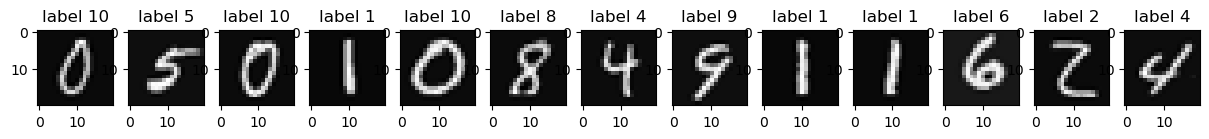

In [5]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion :

In [6]:
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes))
    for true_label, pred_label in zip(y_true, y_pred):
        # Assurer que les étiquettes vraies et prédites sont dans la plage de 0 à num_classes-1
        true_label = np.clip(true_label, 0, num_classes - 1)
        pred_label = np.clip(pred_label, 0, num_classes - 1)
        matrix[true_label][pred_label] += 1
    return matrix


- Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [7]:
def accuracy_score(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
    return correct / len(y_true)


- Recall (True Positive Rate) = TP/(TP + FN)

In [8]:
def recall_score(y_true, y_pred, positive_label):
    tp = 0
    fn = 0
    for i in range(len(y_true)):
        if y_true[i] == positive_label:
            if y_pred[i] == positive_label:
                tp += 1
            else:
                fn += 1
    return tp / (tp + fn)


- Précision = TP/(TP + FP)

In [9]:
def precision_score(y_true, y_pred, positive_label):
    tp = 0
    fp = 0
    for i in range(len(y_true)):
        if y_pred[i] == positive_label:
            if y_true[i] == positive_label:
                tp += 1
            else:
                fp += 1
    return tp / (tp + fp)


- Taux de FP (False Positive Rate) = FP / (FP + TN)

In [10]:
def false_positive_rate(y_true, y_pred, positive_label):
    fp = 0
    tn = 0
    for i in range(len(y_true)):
        if y_pred[i] != positive_label:
            if y_true[i] != positive_label:
                tn += 1
            else:
                fp += 1
    return fp / (fp + tn)


- Spécificité (True Negative Rate) = TN / (TN + FP)

In [11]:
def specificity_score(y_true, y_pred, negative_label):
    tn = 0
    fp = 0
    for i in range(len(y_true)):
        if y_true[i] == negative_label:
            if y_pred[i] == negative_label:
                tn += 1
            else:
                fp += 1
    return tn / (tn + fp)


- Courbe ROC

In [12]:
def roc_curve(y_true, y_pred, positive_label):
    tpr = []
    fpr = []
    thresholds = sorted(set(y_pred), reverse=True)
    for threshold in thresholds:
        binarized_predictions = [1 if pred >= threshold else 0 for pred in y_pred]
        tpr.append(recall_score(y_true, binarized_predictions, positive_label))
        fpr.append(false_positive_rate(y_true, binarized_predictions, positive_label))
    return fpr, tpr


# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [13]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
Xt, Xtt, Yt, Ytt = train_test_split(
      scaled_features, Y, test_size = 0.30)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

K = 1:
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 136.   1.   1.   1.   0.   0.   0.   0.   1.]
 [  0.   3. 127.   7.   5.   0.   2.   3.   8.   4.]
 [  0.   2.   4. 118.   1.   3.   1.   3.   4.   2.]
 [  0.   1.   2.   0. 115.   1.   1.   3.   1.  15.]
 [  0.   0.   0.   8.   2. 133.   4.   1.   4.   4.]
 [  0.   2.   1.   0.   0.   2. 131.   0.   0.   2.]
 [  0.   4.   0.   2.   4.   0.   0. 130.   0.  14.]
 [  0.   0.   1.   5.   1.   9.   2.   0. 121.   6.]
 [  0.   1.   3.   4.  10.   1.   3.   9.   3. 297.]]
Accuracy: 0.8713333333333333
Recall: 0.9540229885057471
Precision: 0.9485714285714286
False Positive Rate: 0.0060377358490566035
Specificity: 0.9540229885057471


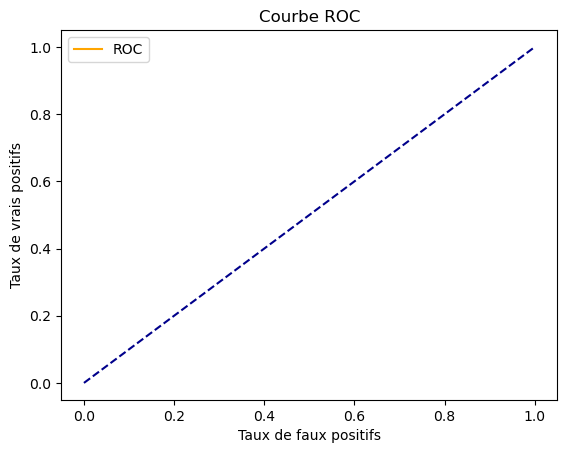



K = 3:
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 136.   1.   0.   0.   0.   0.   0.   2.   1.]
 [  0.   5. 122.   7.   3.   1.   1.   2.  15.   3.]
 [  0.   3.   4. 117.   1.   2.   1.   3.   5.   2.]
 [  0.   6.   1.   0. 107.   2.   1.   0.   2.  20.]
 [  0.   2.   0.  11.   1. 121.   3.   0.  12.   6.]
 [  0.   2.   0.   0.   0.   2. 129.   0.   4.   1.]
 [  0.   4.   2.   2.   4.   1.   0. 125.   0.  16.]
 [  0.   2.   1.   5.   1.   5.   1.   0. 125.   5.]
 [  0.   0.   2.   1.   6.   2.   1.   7.   6. 306.]]
Accuracy: 0.858
Recall: 0.9712643678160919
Precision: 0.949438202247191
False Positive Rate: 0.0037821482602118004
Specificity: 0.9712643678160919


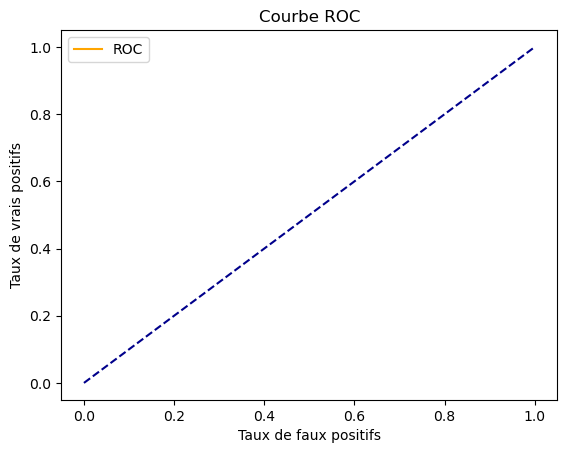

In [17]:
def euclidean_distance(point1, point2):
    # Calculate the Euclidean distance between two points
    return np.sqrt(np.sum((point1 - point2)**2))

def k_nearest_neighbors(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        # Calculate distances between the test point and all points in the training set
        distances = [euclidean_distance(test_point, train_point) for train_point in X_train]
        # Get indices of k nearest neighbors
        nearest_indices = np.argsort(distances)[:k]
        # Get labels of k nearest neighbors
        nearest_labels = [y_train[i] for i in nearest_indices]
        # Predict the label based on majority vote
        predicted_label = max(set(nearest_labels), key=nearest_labels.count)
        predictions.append(predicted_label)
    return predictions



# Méthode 0: K- Plus Proches Voisins
# Tester différentes valeurs de K et évaluer les performances du modèle
K_values = [1, 3, 5, 7, 9]  # Valeurs de K à tester
for k in K_values:
    # Prédire les étiquettes pour les données de test
    y_pred = k_nearest_neighbors(Xt, Yt, Xtt, k)
    # Calculer les métriques de performance
    conf_matrix = confusion_matrix(Ytt, y_pred, num_classes=10)
    acc = accuracy_score(Ytt, y_pred)
    recall = recall_score(Ytt, y_pred, positive_label=10)  # Étiquette positive pour le chiffre 0
    precision = precision_score(Ytt, y_pred, positive_label=10)  # Étiquette positive pour le chiffre 0
    fpr = false_positive_rate(Ytt, y_pred, positive_label=10)  # Étiquette positive pour le chiffre 0
    specificity = specificity_score(Ytt, y_pred, negative_label=10)  # Étiquette négative pour le chiffre 0
    roc_fpr, roc_tpr = roc_curve(Ytt, y_pred, positive_label=10)  # Étiquette positive pour le chiffre 0
    
    # Afficher les résultats
    print(f"K = {k}:")
    #print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {acc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"False Positive Rate: {fpr}")
    print(f"Specificity: {specificity}")
    #le taux de faux positifs (FPR) sur l'axe des abscisses et le taux de vrais positifs (TPR) sur l'autre axe
    import matplotlib.pyplot as plt

    # Définition de la fonction pour afficher la courbe ROC
    def plot_roc_curve(fpr, tpr):
        plt.plot(fpr, tpr, color='orange', label='ROC')
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title('Courbe ROC')
        plt.legend()
        plt.show()

    # Affichage de la courbe ROC pour K = 1
    plot_roc_curve(roc_fpr, roc_tpr)

    
    print("\n")


# Méthode 1: MVS
Machine à Vecteurs de Support

In [26]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

7


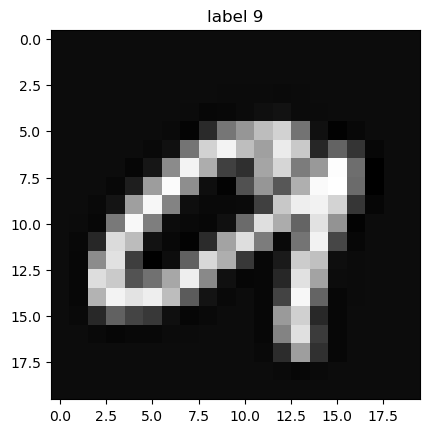

In [27]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 2: Arbres de décision


In [28]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

10


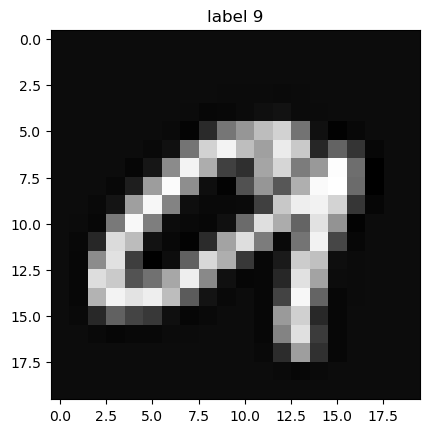

In [29]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [30]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [31]:
# Choisir un image de test 
c=0

In [32]:
model.predict([Xtt[c,:]])

array([10])

In [33]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])

array([[5.39052741e-052, 1.17798434e-092, 9.52703138e-025,
        7.56120379e-087, 7.38868771e-007, 1.16472202e-125,
        4.36290486e-056, 2.17523632e-083, 9.97926771e-117,
        9.99999261e-001]])

Afficher l'image testée

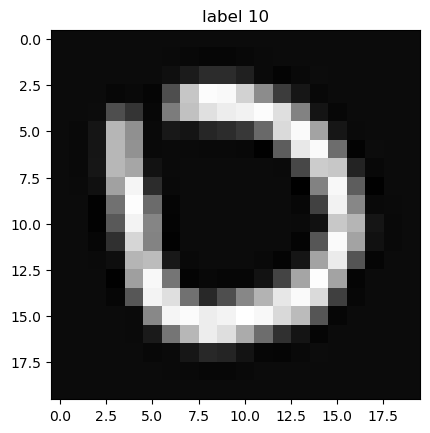

In [34]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

# Appliquer les métriques implementées pour voir le résultat